# Overfitting and Regularization

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [4]:
set_config(display='diagram')

## Settings

In [5]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [6]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

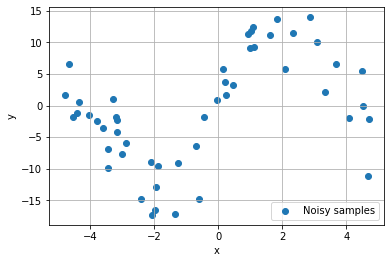

In [7]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

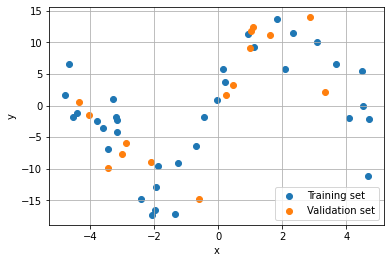

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [9]:
X_train

array([[-4.41916388],
       [-0.0482309 ],
       [-1.88288924],
       [ 0.20068021],
       [-3.1659549 ],
       [ 2.08072578],
       [-1.95757757],
       [-0.43930016],
       [ 4.65632033],
       [-3.29475876],
       [-1.25459881],
       [-2.41220018],
       [ 0.14234438],
       [ 4.48885537],
       [-3.4400548 ],
       [-4.53549587],
       [ 4.69909852],
       [-1.95386231],
       [ 4.50714306],
       [-3.60506139],
       [ 2.31993942],
       [ 4.09320402],
       [ 3.08397348],
       [-1.33638157],
       [-3.77961765],
       [-4.79415506],
       [-2.07855351],
       [-0.68054981],
       [-3.15145544],
       [ 1.11852895],
       [ 3.66176146],
       [-4.65611479],
       [-3.18175033],
       [ 0.92414569],
       [ 1.84233027]])

In [10]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [11]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [12]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

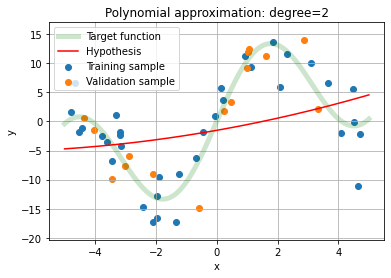

In [13]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

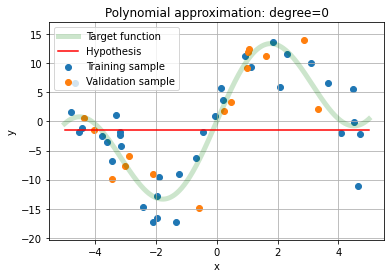

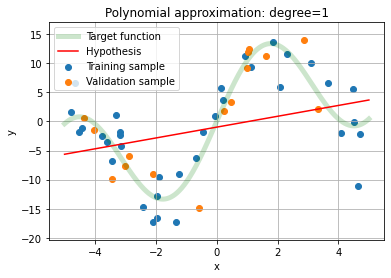

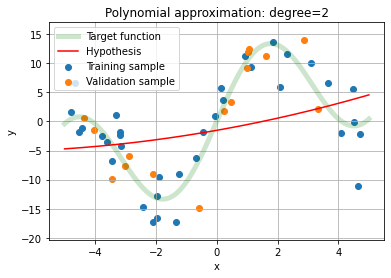

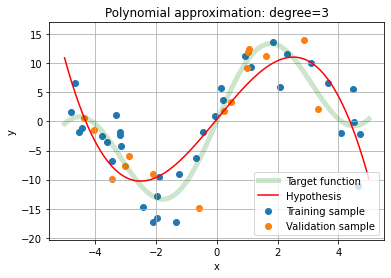

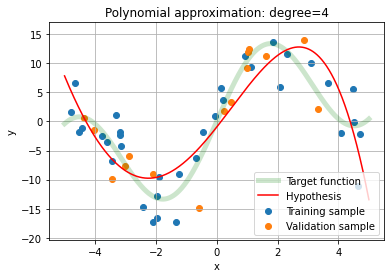

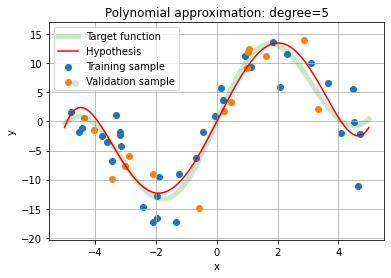

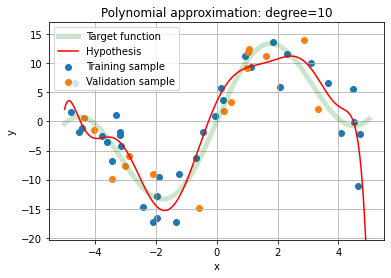

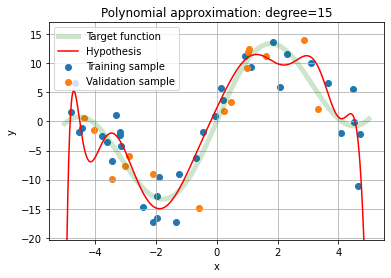

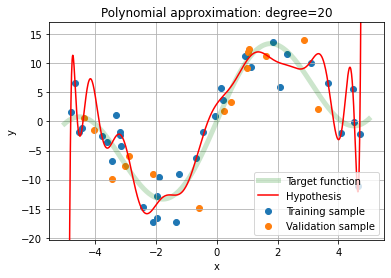

In [14]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

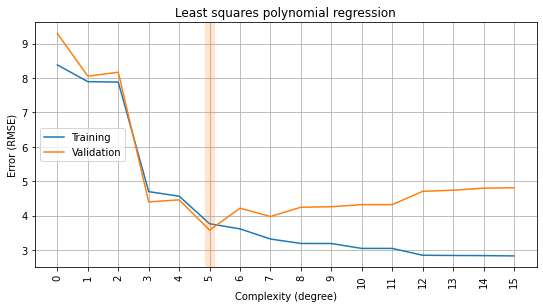

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [16]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

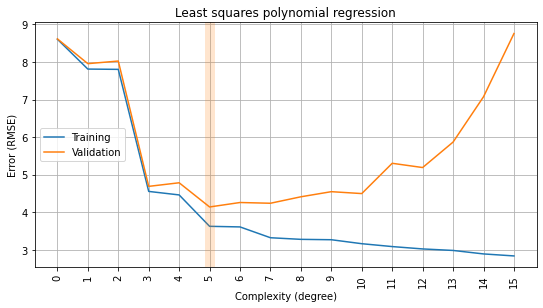

In [17]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [18]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

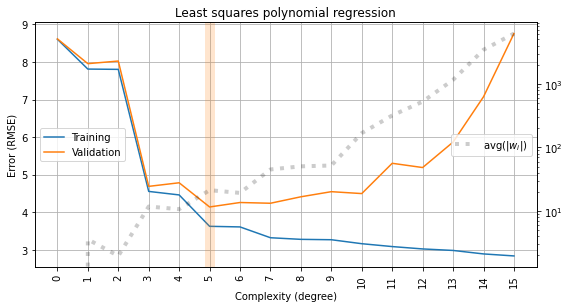

In [19]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

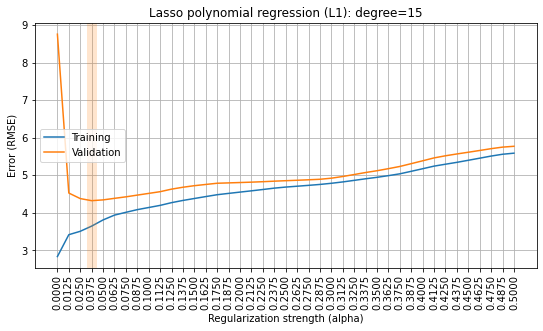

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

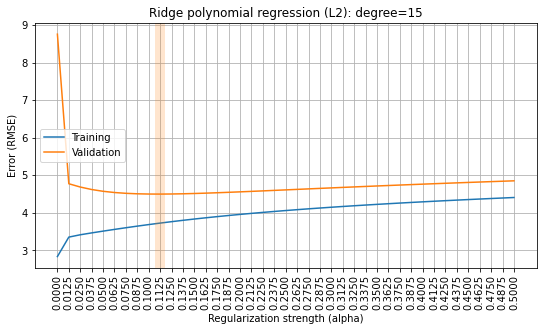

In [21]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [60]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0
...,...
437,178.0
438,104.0
439,132.0
440,220.0


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

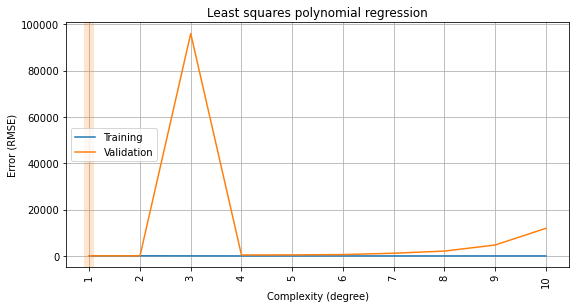

In [23]:
DEGREES = [1,2,3,4,5,6,7,8,9,10]
rmse_train, rmse_valid = [], []
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train)
scaled_xtest = scaler.transform(X_test)

def poly_calc(degree, scaled_xtrain, y_train, regressor):
    polynoms = PolynomialFeatures(degree=degree, include_bias=False)
    xtrain_poly = polynoms.fit_transform(scaled_xtrain)
    lreg_model = regressor
    lreg_model.fit(xtrain_poly, y_train)
    return lreg_model

def poly_pred(lreg_model, degree, scaled_xtest):
    featured_poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_test = featured_poly.fit_transform(scaled_xtest)
    return lreg_model.predict(poly_test)


def build_model(degree, scaled_xtrain, scaled_xtest, y_train, y_test, alpha=0, penalty=None):
    regressor = LinearRegression()
    if alpha == 0:
        regressor = LinearRegression()
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    calculated_polynoms = poly_calc(degree, scaled_xtrain, y_train, regressor)
    predicted_y_train = poly_pred(calculated_polynoms, degree, scaled_xtrain)
    predicted_y_test = poly_pred(calculated_polynoms, degree, scaled_xtest)
    rmse_train.append(rmse(predicted_y_train, y_train))
    rmse_valid.append(rmse(predicted_y_test, y_test))
    return calculated_polynoms
    

for degree in DEGREES:
    build_model(degree, scaled_xtrain, scaled_xtest, y_train, y_test)
    
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Between 1 and 2 degrees, and between 4-7 our model is underfitted;
It's clearly overfitted between 2-4, and gets overfitted from around 9 degrees;
Good fit is around 8.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

It'll take an enormous amount of time and memory to calculate L1 and L2 for each of the 'alphas' for all 10 features at degree=15; I'll use 3 features and degree=5:

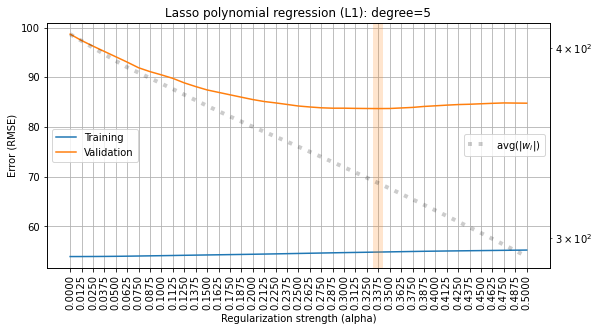

In [71]:
rmse_train, rmse_valid, avg_coef = [], [], []
x = X_diabetes[['age', 'bmi', 'bp']]
X_train, X_test, y_train, y_test = train_test_split(x, y_diabetes, test_size=0.3, random_state=SEED)
scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train)
scaled_xtest = scaler.transform(X_test)


for alpha in ALPHAS:
    model = build_model(5, scaled_xtrain, scaled_xtest, y_train, y_test, alpha=alpha, penalty='L1')
    results = cross_validate(model, 
                             x, y_diabetes, cv=5, return_estimator=True,
                             scoring='neg_root_mean_squared_error')       
    avg_coef.append(np.mean([np.abs(model.coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=5')

#### L2

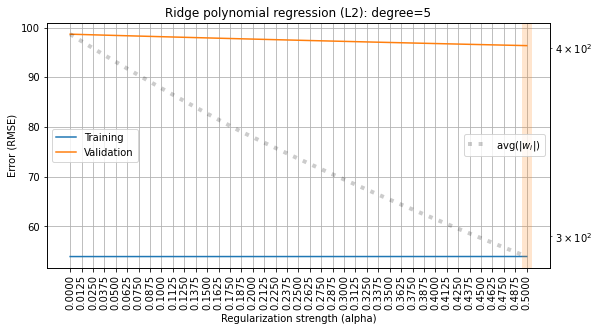

In [83]:
rmse_train, rmse_valid, avg_coef = [], [], []
x = X_diabetes[['age', 'bmi', 'bp']]
X_train, X_test, y_train, y_test = train_test_split(x, y_diabetes, test_size=0.3, random_state=SEED)
scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train)
scaled_xtest = scaler.transform(X_test)


for alpha in ALPHAS:
    model = build_model(5, scaled_xtrain, scaled_xtest, y_train, y_test, alpha=alpha, penalty='L2')
    results = cross_validate(model, 
                             x, y_diabetes, cv=5, return_estimator=True,
                             scoring='neg_root_mean_squared_error')       
    avg_coef.append(
        np.mean([np.abs(model.coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=5')

#### Summary

Both L1 and L2 application showed that even when alpha is increasing, the error did not decrease much; perhaps this is due to the fact that the features that I selected really have a large influence on the target.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [81]:
for alpha in ALPHAS: 
    print(build_model(5, scaled_xtrain, scaled_xtest, y_train, y_test, alpha=alpha, penalty='L1').coef_)

[[ 38.6737122   38.32225817  35.46544824 -20.58966409  16.14339546
   14.26592827   6.5614334  -19.54321833   7.18873052 -34.25977569
    0.70688034  20.48990275   5.46344047   3.6576925  -31.84699207
    0.65624989 -21.04367802  28.55135233 -22.06316459   6.58719591
   -6.0447449   -8.32853987   6.22396285   5.37097551  10.78353213
   -7.80528411   8.62131076 -15.6343822    3.31077911  -2.21106485
    9.51041941 -14.31216331  16.30920388  -5.78547296   5.45021369
    4.15396164  -8.29973667   1.4147198   -7.53581167  16.50832329
  -13.69887795  27.24211501 -22.0701179   -1.61460726   3.09392157
   -4.24489019  -0.20894709   8.43297271   0.84773977   2.35480256
   -5.16707823   2.67071174   4.01244368  -6.91736432   4.56285886]]
[ 37.58360796  39.18477943  34.68102273 -19.78195783  14.27384605
  14.80716077   6.0334723  -17.68628848   6.20281292 -33.4039209
   0.10159953  19.88582778   5.71835626   3.46191083 -30.89607927
   0.49013395 -20.03474221  26.76457104 -21.15676072   6.3962640

[ 27.96337391  43.63072051  28.70037586 -11.51105481   0.
  17.54508453   2.18871604  -2.72829018  -0.         -25.82373951
   0.          11.99306251   6.25581542   0.65052064 -20.88942822
   0.         -11.19053429  11.87305757 -13.75503619   4.46396135
  -3.12453888  -6.07270564   0.70275966   7.26924623   6.76083825
  -1.79365979   1.1179579   -4.96533621   0.588936     0.57583365
   0.42798593  -4.12497937   6.96964095  -2.51619347   4.21184522
   3.41145461  -5.73544338   0.73996621  -5.38570054  11.49808598
 -10.40353282  21.14130925 -16.68532443  -0.           1.51148007
  -3.04969633  -0.46194004   6.65119767   0.13385113   1.39954234
  -3.05303281   1.75964489   1.71542661  -2.47215199   2.59524879]
[ 27.16797082  43.94400371  28.15868538 -10.95897719   0.
  17.25496767   1.6630951   -2.11435979  -0.         -25.08324112
   0.          11.42942205   6.14045596   0.39526254 -20.10512243
   0.         -10.4247821   10.8248044  -13.20739793   4.32032536
  -3.20271945  -5.7420865

[ 1.21819676e+01  4.56313197e+01  2.16802587e+01 -2.94238130e+00
 -0.00000000e+00  8.88845097e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -9.85798904e+00  0.00000000e+00  0.00000000e+00
  2.19356465e+00  0.00000000e+00 -8.16451940e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -6.27858644e+00  2.01638084e+00
 -3.30678074e+00 -0.00000000e+00 -1.46208717e-01  7.99483639e+00
  7.76921532e-01 -2.60908286e+00 -0.00000000e+00 -0.00000000e+00
  5.05631599e-01  1.06797986e+00 -0.00000000e+00 -2.51681657e-01
  2.15237070e+00 -1.07246278e+00  1.53754467e+00  1.94662631e+00
 -1.14784201e+00  1.97828438e-01 -1.68067887e+00  4.69137817e+00
 -9.40325597e+00  1.64597104e+01 -9.40516232e+00  3.13304426e-02
  2.56924608e+00 -3.80155046e+00 -0.00000000e+00  3.99130639e+00
 -1.08886307e-01  1.25969938e+00 -3.75686933e+00  1.65926142e+00
  0.00000000e+00  6.00365531e-02  1.24675338e+00]
[11.69923271 45.54600232 21.44487108 -2.71042466 -0.          8.86686586
  0.         -0.         -0.    

#### L2

In [82]:
for alpha in ALPHAS: 
    print(build_model(5, scaled_xtrain, scaled_xtest, y_train, y_test, alpha=alpha, penalty='L2').coef_)

[[ 38.6737122   38.32225817  35.46544824 -20.58966409  16.14339546
   14.26592827   6.5614334  -19.54321833   7.18873052 -34.25977569
    0.70688034  20.48990275   5.46344047   3.6576925  -31.84699207
    0.65624989 -21.04367802  28.55135233 -22.06316459   6.58719591
   -6.0447449   -8.32853987   6.22396285   5.37097551  10.78353213
   -7.80528411   8.62131076 -15.6343822    3.31077911  -2.21106485
    9.51041941 -14.31216331  16.30920388  -5.78547296   5.45021369
    4.15396164  -8.29973667   1.4147198   -7.53581167  16.50832329
  -13.69887795  27.24211501 -22.0701179   -1.61460726   3.09392157
   -4.24489019  -0.20894709   8.43297271   0.84773977   2.35480256
   -5.16707823   2.67071174   4.01244368  -6.91736432   4.56285886]]
[[ 38.58957568  38.34533212  35.41825388 -20.54695507  16.05821795
   14.29056652   6.53817059 -19.45742852   7.14848239 -34.19512944
    0.69661058  20.44475913   5.47391231   3.64607195 -31.78094221
    0.65782927 -20.98359125  28.45440243 -22.01062509   6.57

[[ 35.66910582  38.95831572  33.86131069 -19.0599826   13.29884602
   14.98547194   5.7426303  -16.63655263   5.85639843 -31.9337766
    0.47698994  18.80282298   5.78357047   3.19969162 -29.45251013
    0.777663   -18.94835547  25.25621925 -20.26213483   6.23544488
   -5.51049854  -7.97775701   5.32343716   5.70935275  10.04113961
   -6.83206276   7.29759908 -13.72843665   2.82144503  -1.7074146
    7.97946655 -12.54185961  14.64493836  -5.18120225   5.09247628
    4.07031898  -7.71522744   1.2365873   -7.10761327  15.42866867
  -13.16075961  26.0005927  -20.904932    -1.39120008   2.8596888
   -4.16662894  -0.1917115    8.10666933   0.6952408    2.16627248
   -4.8786575    2.5968477    3.52283038  -6.08616862   4.17473059]]
[[ 35.59887453  38.9687797   33.82538268 -19.02411434  13.23687309
   14.99859259   5.7237729  -16.57228698   5.82775881 -31.87896635
    0.47453817  18.76200186   5.78981826   3.18812762 -29.39586667
    0.78206456 -18.90038935  25.18293574 -20.22161892   6.22715

#### Summary

It's indeed happening. There're zero coefficients after L1 application.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [77]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

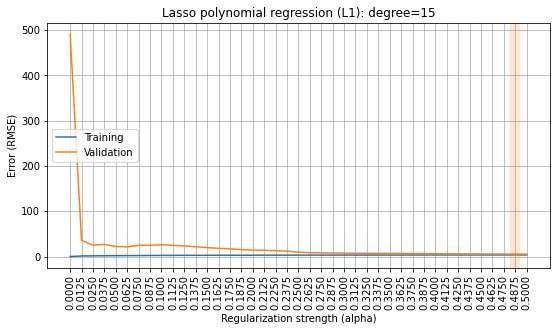

In [78]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

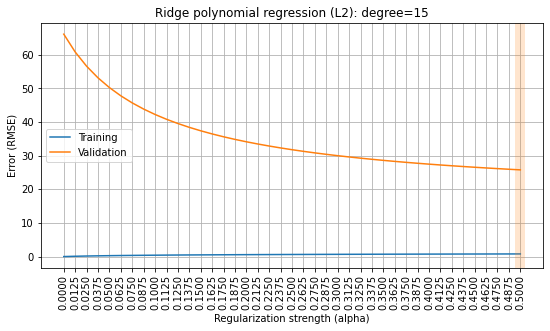

In [79]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=2,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary



Scaling is indeed important, especially in the case when we use machine learning methods that are sensitive to the range of the data points.
When our features are of different range, usually higher ranged features tend to play a larger role while training the model. This could overestimate some features, and underestimate the others.
Scaling levereges them.